In [30]:
"""
Load Shohei Ohtani’s 2023 Statcast batting data from the MLB database via the pybaseball API
This cell sets up the analysis by importing required libraries and pulling raw pitch-level data for the full season
The data will be used to analyze batting average by zone and pitch type
"""

# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
from matplotlib.ticker import FixedLocator, FixedFormatter

# Import Statcast data functions
from pybaseball import statcast_batter

# Configure display settings
%matplotlib inline
sns.set(style="whitegrid")

# Define Shohei Ohtani's player ID
ohtani_id = 660271

# Load 2023 Statcast batting data
batting_data = statcast_batter('2023-03-01', '2023-10-01', ohtani_id)


Gathering Player Data


In [ ]:
"""
Defines a function to calculate and plot batting average in a 5x5 pitch location grid
Filters by pitch type, bins pitch locations, calculates batting average per grid cell, and visualizes with a heatmap
Used to compare performance against different pitch categories and visualize damage zones
"""

def plot_ba_heatmap(df, pitch_types, title):
    """
    Plots a 5x5 heatmap of batting average by pitch location for given pitch types.
    """
    # Filter to selected pitch types with valid batted ball outcomes
    subset = df[df['pitch_type'].isin(pitch_types) & df['events'].notna()].copy()
    if subset.empty:
        print(f"No batted balls for {title}")
        return

    # Identify hits
    hit_events = ['single', 'double', 'triple', 'home_run']
    subset['hit'] = subset['events'].isin(hit_events).astype(int)

    # Bin horizontal and vertical pitch locations
    x_bins = np.linspace(-1.5, 1.5, 6)
    z_bins = np.linspace(1.0, 4.5, 6)
    subset['x_bin'] = pd.cut(subset['plate_x'], bins=x_bins, labels=False)
    subset['z_bin'] = pd.cut(subset['plate_z'], bins=z_bins, labels=False)

    # Calculate batting average and pitch count per bin
    zone_stats = (
        subset.groupby(['z_bin', 'x_bin'])
              .agg(ba=('hit', 'mean'), count=('hit', 'size'))
              .reset_index()
    )

    # Mask low-sample cells
    zone_stats.loc[zone_stats['count'] < 5, 'ba'] = np.nan

    # Create full 5x5 grid
    full_grid = pd.MultiIndex.from_product(
        [range(5), range(5)], names=['z_bin', 'x_bin']
    ).to_frame(index=False)

    # Merge with actual data
    merged = pd.merge(full_grid, zone_stats, on=['z_bin', 'x_bin'], how='left')

    # Pivot to 2D grid format
    heatmap_data = merged.pivot(index='z_bin', columns='x_bin', values='ba')
    mask = heatmap_data.isna()

    # Define custom colormap
    from matplotlib import colormaps
    cmap = colormaps['coolwarm'].copy()
    cmap.set_bad(color='white')

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        annot=True,
        fmt='.3f',
        linewidths=0.5,
        square=True,
        vmin=0.0,
        vmax=0.400,
        center=0.200,
        mask=mask,
        annot_kws={'color': 'black', 'fontname': 'Arial'},
        cbar_kws={
            'label': 'Batting Average',
            'shrink': 0.5,
            'ticks': [0.0, 0.200, 0.400]
        }
    )

    # Format colorbar
    cbar = ax.collections[0].colorbar
    cbar.set_ticklabels([".000", ".200", ".400"])
    cbar.set_label("Batting Average", fontweight='bold', fontname='Arial')

    # Clean up text formatting
    for text in ax.texts:
        val = text.get_text()
        if val.startswith("0."):
            text.set_text(val[1:])
        elif val.startswith("1.0"):
            text.set_text("1.000")

    # Set plot labels
    plt.title(f"vs. {title}", fontsize=14, fontweight='bold', fontname='Arial')
    plt.xlabel("Horizontal Location — Catcher’s View", fontweight='bold', fontname='Arial')
    plt.ylabel("Vertical Location", fontweight='bold', fontname='Arial')
    plt.gca().invert_yaxis()

    # Draw strike zone rectangle
    plt.gca().add_patch(
        plt.Rectangle((1, 1), 3, 3, fill=False, edgecolor='black', linewidth=2)
    )

    # Show plot
    plt.savefig(f"ohtani_ba_{title.lower().replace(' ', '_')}.png", dpi=300, bbox_inches='tight')
    plt.show()


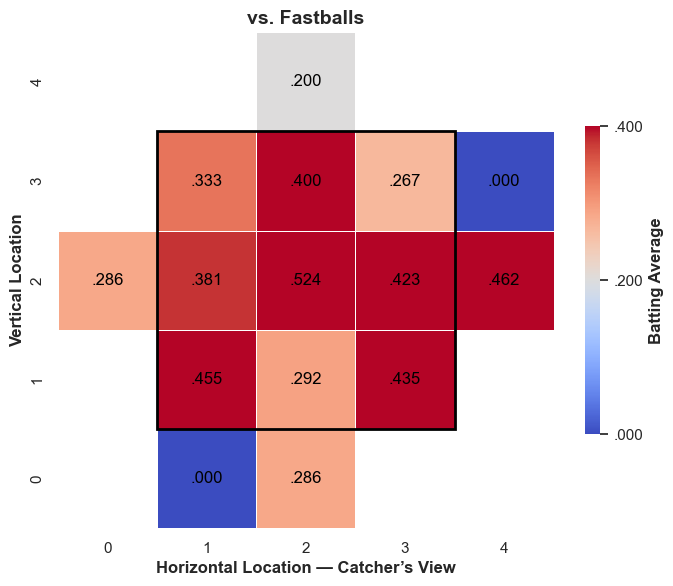

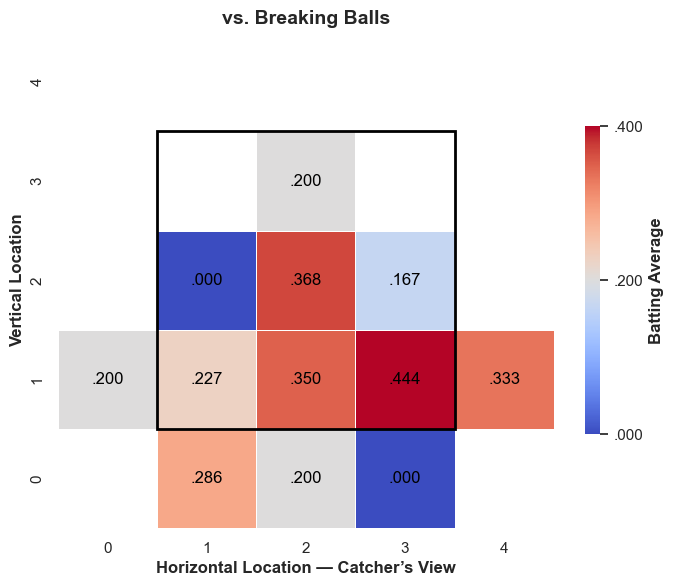

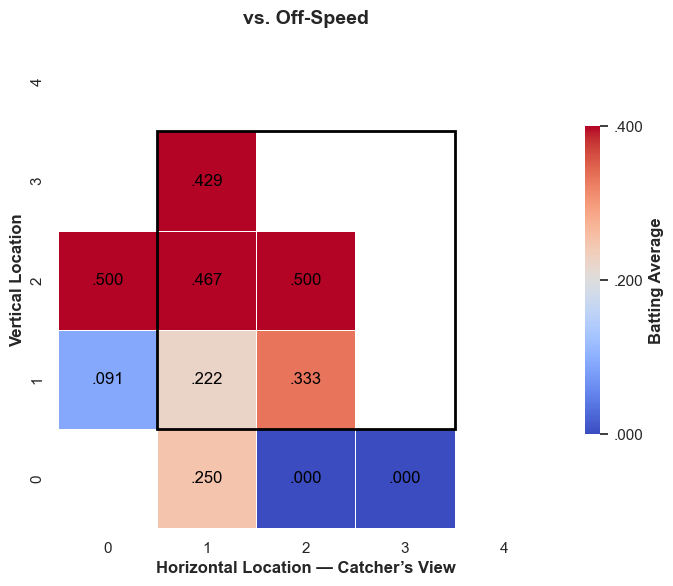

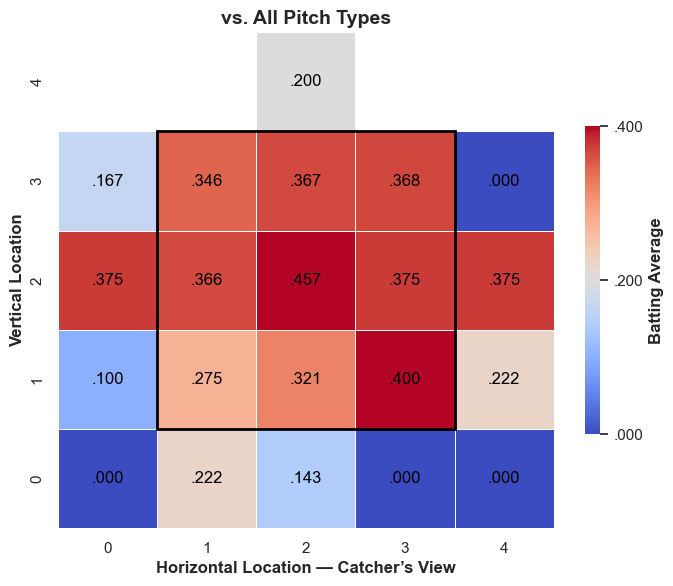

In [40]:
"""
Calls the batting average heatmap function for each pitch category
Generates visual comparisons of Ohtani’s damage zones against fastballs, breaking balls, off-speed pitches, and all pitches combined
"""

# Fastballs: 4-seam, sinker, cutter
plot_ba_heatmap(batting_data, ['FF', 'SI', 'FC'], "Fastballs")

# Breaking balls: slider, curveball, knuckle curve, slurve, sweeper
plot_ba_heatmap(batting_data, ['SL', 'CU', 'KC', 'SV', 'ST'], "Breaking Balls")

# Off-speed pitches: changeup, splitter, forkball
plot_ba_heatmap(batting_data, ['CH', 'FS', 'FO'], "Off-Speed")

# All pitch types combined
plot_ba_heatmap(batting_data, batting_data['pitch_type'].dropna().unique(), "All Pitch Types")